# Heart Disease Prediction using Machine Learning Approach


Heart Disease (including Coronary Heart Disease, Hypertension, and Stroke) remains the No. 1
cause of death in the US.The Heart Disease and Stroke Statistics—2019 Update from the **American Heart Association** indicates that:
* 116.4 million, or 46% of US adults are estimated to have hypertension. These are findings related to the new 2017 Hypertension Clinical Practice Guidelines.
* On average, someone dies of CVD every 38 seconds. About 2,303 deaths from CVD each day, based on 2016 data.
* On average, someone dies of a stroke every 3.70 minutes. About 389.4 deaths from stroke each day, based on 2016 data.

In this notebook i will try to unleash useful insights using this heart disease datasets and by building stacked ensemble model by combining the power of best performing machine learning algorithms.

This notebook is divided into 13 major steps which are as follows:

1. [Data description](#data-desc)
2. [Importing Libraries & setting up environment](#imp-lib)
3. [Loading dataset](#data-load)
4. [Data Cleaning & Preprocessing](#data-prep)
5. [Exploratory Data Analysis](#data-eda)
6. [OUtlier Detection & Removal](#data-out)
7. [Training & Test Split](#data-train)
8. [Cross Validation](#cross-val)
9. [Model Building](#data-model)
10. [Model evaluation & comparison](#model-eval)<br>
11. [Feature Selection](#model-eval)<br>
12. [Model Evaluation](#model-inter)
13. [Conclusion](#data-conc)

## 2. Importing Libraries<a id='imp-lib'></a>

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

# data wrangling & pre-processing
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

#model validation
from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef
from sklearn import metrics

# cross validation
from sklearn.model_selection import StratifiedKFold

# machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
import xgboost as xgb
from catboost import CatBoostClassifier


from scipy import stats


In [3]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


## 3. Loading Dataset<a id='data-load'></a>

In [4]:
dt = pd.read_csv('/content/Mydrive/MyDrive/M.tech 2nd sem/PSA/Term Project/Heart-Disease-Prediction-Using-Machine-Learning-Ensemble-master/heart_statlog_cleveland_hungary_final.csv')

Lets see some of the sample entries of dataset

In [5]:
dt.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


As we can see from above dataset entries some of the features should be nominal and to be encoded as their category type. In the next step we will be encoding features to their respective category as per the dataset description.

## 4. Data Cleaning & Preprocessing <a id='data-prep'></a>
 In this step we will first change the name of columns as some of the columns have weird naming pattern and then we will encode the features into categorical variables

In [6]:
# renaming features to proper name
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope','target']

In [7]:
# converting features to categorical features 

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'



dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'



dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt["sex"] = dt.sex.apply(lambda  x:'male' if x==1 else 'female')

In [8]:
dt['chest_pain_type'].value_counts()

asymptomatic        625
non-anginal pain    283
atypical angina     216
typical angina       66
Name: chest_pain_type, dtype: int64

In [9]:
dt['rest_ecg'].value_counts()

normal                          684
left ventricular hypertrophy    325
ST-T wave abnormality           181
Name: rest_ecg, dtype: int64

In [10]:
dt['st_slope'].value_counts()

flat           582
upsloping      526
downsloping     81
0                1
Name: st_slope, dtype: int64

In [11]:
#dropping row with st_slope =0
dt.drop(dt[dt.st_slope ==0].index, inplace=True)
#checking distribution
dt['st_slope'].value_counts()

flat           582
upsloping      526
downsloping     81
Name: st_slope, dtype: int64

In [12]:
# checking the top 5 entries of dataset after feature encoding
dt.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,target
0,40,male,atypical angina,140,289,0,normal,172,0,0.0,upsloping,0
1,49,female,non-anginal pain,160,180,0,normal,156,0,1.0,flat,1
2,37,male,atypical angina,130,283,0,ST-T wave abnormality,98,0,0.0,upsloping,0
3,48,female,asymptomatic,138,214,0,normal,108,1,1.5,flat,1
4,54,male,non-anginal pain,150,195,0,normal,122,0,0.0,upsloping,0


As we can see features are encoded sucessfully to their respective categories. Next we will be checking if there is any missing entry or not ?

In [13]:
## Checking missing entries in the dataset columnwise
dt.isna().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate_achieved    0
exercise_induced_angina    0
st_depression              0
st_slope                   0
target                     0
dtype: int64

So, there are no missing entries in the dataset thats great. Next we will move towards exploring the dataset by performing detailed EDA

## 5. Exploratory Data Analysis (EDA) <a id='data-eda'></a>

In [14]:
# first checking the shape of the dataset
dt.shape

(1189, 12)

# So, there are total 1189 records and 11 features with 1 target variable. Lets check the summary of numerical and categorical features.

In [15]:
# summary statistics of numerical columns
dt.describe(include =[np.number])


,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,53.708158,132.138772,210.376787,0.212784,139.739277,0.387721,0.923549,0.528175
std,9.352961,18.369251,101.462185,0.409448,25.527386,0.487435,1.086464,0.499416
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,229.000000,0.000000,141.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,270.000000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


As we can see from above description resting_blood_pressure and cholestrol have some outliers as they have minimum value of 0 whereas cholestrol has outlier on upper side also having maximum value of 603.

In [16]:
# summary statistics of categorical columns
dt.describe(include =[np.object])

,sex,chest_pain_type,rest_ecg,st_slope
count,1189,1189,1189,1189
unique,2,4,3,3
top,male,asymptomatic,normal,flat
freq,908,625,683,582


### Distribution of Heart disease (target variable)

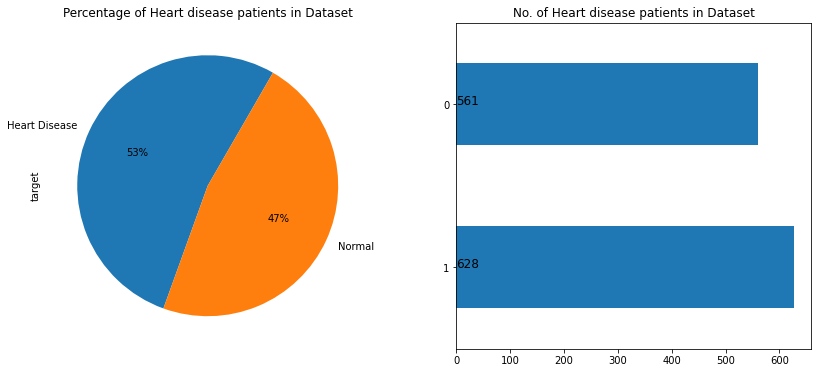

In [17]:
# Plotting attrition of employees
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1 = dt['target'].value_counts().plot.pie( x="Heart disease" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Heart Disease","Normal"], startangle = 60,ax=ax1);
ax1.set(title = 'Percentage of Heart disease patients in Dataset')

ax2 = dt["target"].value_counts().plot(kind="barh" ,ax =ax2)
for i,j in enumerate(dt["target"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'No. of Heart disease patients in Dataset')
plt.show()

The dataset is balanced having 629 heart disease patients and 561 normal patients

### Checking Gender & Agewise Distribution

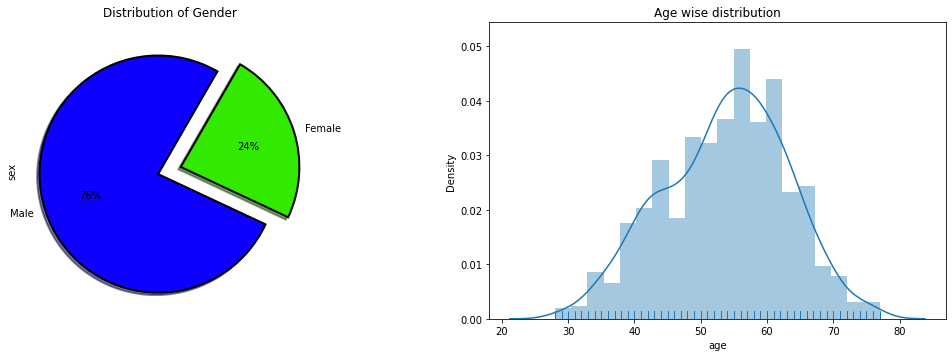

male      908
female    281
Name: sex, dtype: int64
0       40
1       49
2       37
3       48
4       54
        ..
1185    45
1186    68
1187    57
1188    57
1189    38
Name: age, Length: 1189, dtype: int64


In [19]:
plt.figure(figsize=(18,12))
plt.subplot(221)
dt["sex"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",5),startangle = 60,labels=["Male","Female"],
wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,.1],shadow =True)
plt.title("Distribution of Gender")
plt.subplot(222)
ax= sns.distplot(dt['age'], rug=True)
plt.title("Age wise distribution")
plt.show()
print(dt["sex"].value_counts())
print(dt['age'])

As we can see from above plot, in this dataset males percentage is way too higher than females where as average age of patients is around 55.

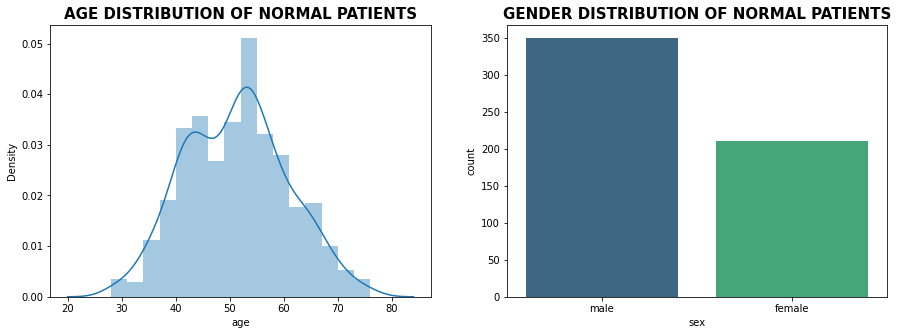

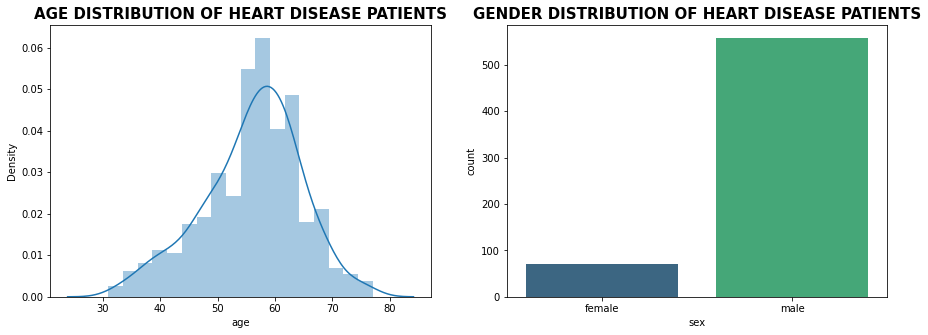

In [21]:
# creating separate df for normal and heart patients

attr_1=dt[dt['target']==1]

attr_0=dt[dt['target']==0]

# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_0['age'])
plt.title('AGE DISTRIBUTION OF NORMAL PATIENTS', fontsize=15, weight='bold')

ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_0['sex'], palette='viridis')
plt.title('GENDER DISTRIBUTION OF NORMAL PATIENTS', fontsize=15, weight='bold' )
plt.show()

#plotting heart patients

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_1['age'])
plt.title('AGE DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=15, weight='bold')

ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1['sex'], palette='viridis')
plt.title('GENDER DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=15, weight='bold' )
plt.show()

As we can see from above plot more patients accounts for heart disease in comparison to females whereas mean age for heart disease patients is around 58 to 60 years

### Distribution of Chest Pain Type

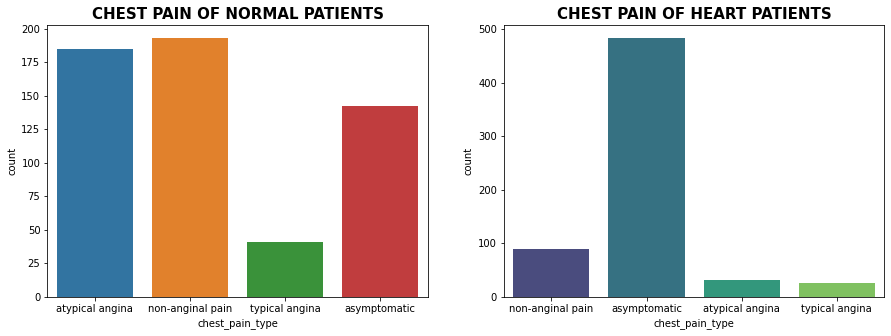

1       non-anginal pain
3           asymptomatic
8           asymptomatic
11       atypical angina
13          asymptomatic
              ...       
1184        asymptomatic
1185      typical angina
1186        asymptomatic
1187        asymptomatic
1188     atypical angina
Name: chest_pain_type, Length: 628, dtype: object


In [22]:
# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0['chest_pain_type'])
plt.title('CHEST PAIN OF NORMAL PATIENTS', fontsize=15, weight='bold')

#plotting heart patients
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1['chest_pain_type'], palette='viridis')
plt.title('CHEST PAIN OF HEART PATIENTS', fontsize=15, weight='bold' )
plt.show()
print(attr_1['chest_pain_type'])

In [ ]:
#Exploring the Heart Disease patients based on Chest Pain Type
plot_criteria= ['chest_pain_type', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(dt[plot_criteria[0]], dt[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
chest_pain_type,,
asymptomatic,25.310000,76.910000
atypical angina,32.980000,4.940000
non-anginal pain,34.400000,14.170000
typical angina,7.310000,3.980000


As we can see from above plot **76%** of the chest pain type of the heart disease patients have asymptomatic chest pain. 

Asymptomatic heart attacks medically known as **silent myocardial infarction (SMI)** annually accounts for around 45-50% of morbidities due to cardiac ailments and even premature deaths in India. The incidences among middle aged people experiencing SMI is twice likely to develop in males than females. The symptoms of SMI being very mild in comparison to an actual heart attack; it is described as a silent killer. Unlike the symptoms in a normal heart attack which includes extreme chest pain, stabbing pain in the arms, neck & jaw, sudden shortness of breath, sweating and dizziness, the symptoms of SMI are very brief and hence confused with regular discomfort and most often ignored.

[reference](https://www.maxhealthcare.in/blogs/cardiology/rise-cases-asymptomatic-heart-attacks-amongst-middle-aged-people)

### Distribution of Rest ECG

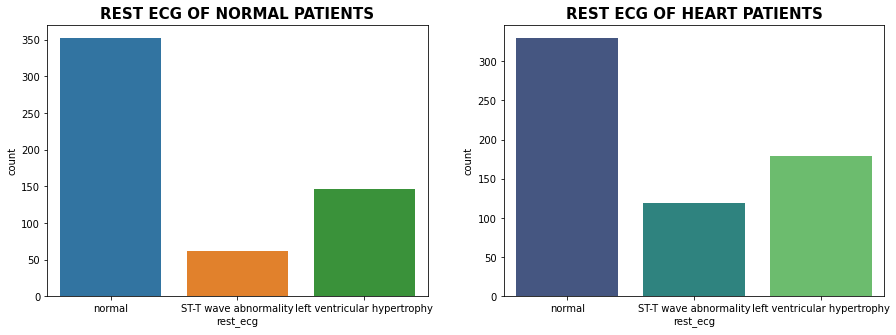

In [ ]:
# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0['rest_ecg'])
plt.title('REST ECG OF NORMAL PATIENTS', fontsize=15, weight='bold')

#plotting heart patients
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1['rest_ecg'], palette='viridis')
plt.title('REST ECG OF HEART PATIENTS', fontsize=15, weight='bold' )
plt.show()

In [ ]:
#Exploring the Heart Disease patients based on REST ECG
plot_criteria= ['rest_ecg', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(dt[plot_criteria[0]], dt[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
rest_ecg,,
ST-T wave abnormality,11.050000,18.950000
left ventricular hypertrophy,26.020000,28.500000
normal,62.920000,52.550000


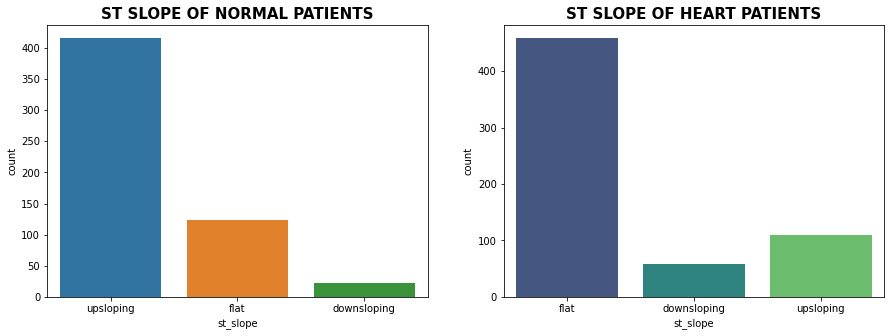

In [ ]:
# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0['st_slope'])
plt.title('ST SLOPE OF NORMAL PATIENTS', fontsize=15, weight='bold')

#plotting heart patients
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1['st_slope'], palette='viridis')
plt.title('ST SLOPE OF HEART PATIENTS', fontsize=15, weight='bold' )
plt.show()

In [ ]:
#Exploring the Heart Disease patients based on ST Slope
plot_criteria= ['st_slope', 'target']
cm = sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(dt[plot_criteria[0]], dt[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

target,0,1
st_slope,,
downsloping,3.920000,9.390000
flat,21.930000,73.090000
upsloping,74.150000,17.520000



The ST segment /heart rate slope (ST/HR slope), has been proposed as a more accurate ECG criterion for diagnosing significant coronary artery disease (CAD) in most of the research papers. 

As we can see from above plot upsloping is positive sign as 74% of the normal patients have upslope where as 72.97% heart patients have flat sloping.

### Distribution of Numerical features

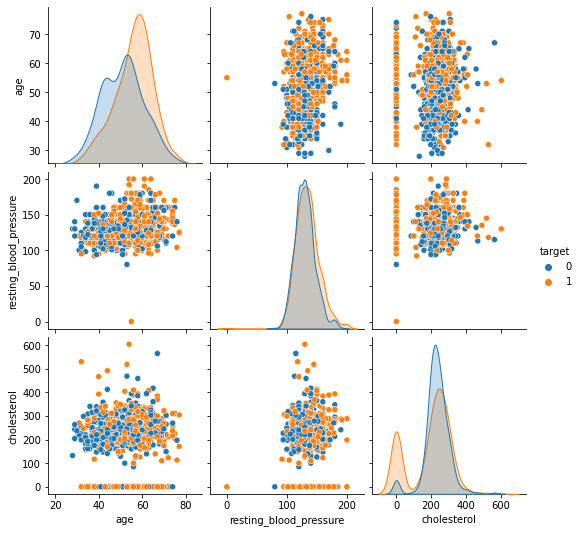

In [ ]:
sns.pairplot(dt, hue = 'target', vars = ['age', 'resting_blood_pressure', 'cholesterol'] )

From the above plot it is clear that as the age increases chances of heart disease increases

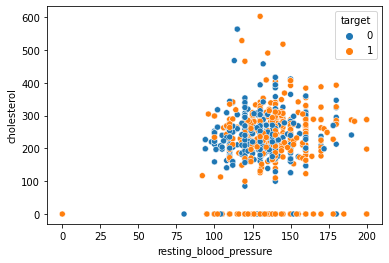

In [ ]:
sns.scatterplot(x = 'resting_blood_pressure', y = 'cholesterol', hue = 'target', data = dt)

From the above plot we can see outliers clearly as for some of the patients cholestrol is 0 whereas for one patient both cholestrol and resting bp is 0 which is may be due to missing entries we will filter these ouliers later

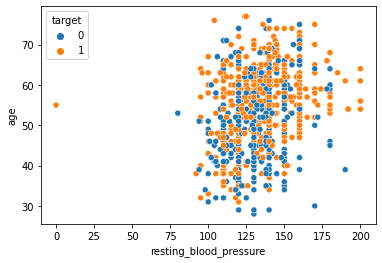

In [ ]:
sns.scatterplot(x = 'resting_blood_pressure', y = 'age', hue = 'target', data = dt)

## 6. Outlier Detection & Removal <a id='data-out'></a>

In [ ]:
# filtering numeric features as age , resting bp, cholestrol and max heart rate achieved has outliers as per EDA

dt_numeric = dt[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved']]

In [ ]:
dt_numeric.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved
0,40,140,289,172
1,49,160,180,156
2,37,130,283,98
3,48,138,214,108
4,54,150,195,122


In [ ]:
# calculating zscore of numeric columns in the dataset
z = np.abs(stats.zscore(dt_numeric))
print(z)

[[1.46626567 0.4281359  0.7752277  1.26430092]
 [0.5035987  1.51737007 0.29951621 0.63725935]
 [1.78715466 0.11648118 0.71606748 1.63576637]
 ...
 [0.35210527 0.11648118 0.78265797 0.96953469]
 [0.35210527 0.11648118 0.2526458  1.34268112]
 [1.68019167 0.31921249 0.34881639 1.30349102]]


from these points it is diffciult to say which points are outliers so we will now define threshold

In [ ]:
# Defining threshold for filtering outliers 
threshold = 3
print(np.where(z > 3))

(array([  30,   76,  109,  149,  242,  366,  371,  391,  400,  450,  592,
        617,  733,  760, 1012, 1038, 1074]), array([2, 2, 1, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1]))


Don’t be confused by the results. The first array contains the list of row numbers and second array respective column numbers, which mean z[30][2] have a Z-score higher than 3. There are total 17 data points which are outliers.

In [ ]:
#filtering outliers retaining only those data points which are below threshhold
dt = dt[(z < 3).all(axis=1)]

In [ ]:
# checking shape of dataset after outlier removal
dt.shape

(1172, 12)

Great !! all the 17 data points which are outliers are now removed.

Now before splitting dataset into train and test we first encode categorical variables as dummy variables and segregate feature and target variable.

In [ ]:
## encoding categorical variables
dt = pd.get_dummies(dt, drop_first=True)

dt.head()


,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
0,40,140,289,0,172,0,0.0,0,1,1,0,0,0,1,0,1
1,49,160,180,0,156,0,1.0,1,0,0,1,0,0,1,1,0
2,37,130,283,0,98,0,0.0,0,1,1,0,0,0,0,0,1
3,48,138,214,0,108,1,1.5,1,0,0,0,0,0,1,1,0
4,54,150,195,0,122,0,0.0,0,1,0,1,0,0,1,0,1


In [ ]:
# checking the shape of dataset
dt.shape

(1172, 16)

In [ ]:
# segregating dataset into features i.e., X and target variables i.e., y
X = dt.drop(['target'],axis=1)
y = dt['target']

## Checking Correlation 

In [ ]:
#Correlation with Response Variable class

#X.corrwith(y).plot.bar(
        #figsize = (16, 4), title = "Correlation with Diabetes", fontsize = 15,
       # rot = 90, grid = True)


## 7. Train Test Split <a id='data-train'></a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=None)

In [ ]:
## checking distribution of traget variable in train test split
print('Distribution of traget variable in training set')
print(y_train.value_counts())

print('Distribution of traget variable in test set')
print(y_test.value_counts())

Distribution of traget variable in training set
1    491
0    446
Name: target, dtype: int64
Distribution of traget variable in test set
1    123
0    112
Name: target, dtype: int64


In [ ]:
print('------------Training Set------------------')
print(X_train.shape)
print(y_train.shape)

print('------------Test Set------------------')
print(X_test.shape)
print(y_test.shape)

------------Training Set------------------
(937, 15)
(937,)
------------Test Set------------------
(235, 15)
(235,)


### feature normalization
In this step we will normalize all the numeric feature in the range of 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
61,0.306122,0.666667,0.517312,0,0.800000,0,0.243902,0,0,1,0,0,1,0,1
332,0.571429,0.333333,0.000000,1,0.111111,0,0.121951,1,0,0,0,0,0,0,1
689,0.857143,0.723810,0.498982,0,0.562963,0,0.243902,1,1,0,0,1,0,0,1
27,0.489796,0.380952,0.578411,0,0.377778,0,0.243902,1,1,0,0,0,1,0,1
773,0.551020,0.571429,0.441955,0,0.325926,1,0.926829,1,0,0,0,0,1,0,0


In [ ]:
X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
211,0.408163,0.247619,0.535642,1,0.318519,0,0.243902,1,0,0,0,0,1,1,0
562,0.530612,0.495238,0.370672,0,0.548148,0,0.256098,1,1,0,0,0,0,0,1
674,0.653061,0.380952,0.362525,1,0.214815,0,0.243902,0,0,1,0,0,1,0,1
591,0.714286,0.533333,0.336049,0,0.488889,0,0.268293,1,1,0,0,0,0,0,1
637,0.795918,0.380952,0.466395,0,0.459259,1,0.560976,1,0,0,0,1,0,1,0


## 8. Cross Validation <a id='cross-val'></a>

In this step, we will build different baseline models and perform 10-fold cross validation to filter top performing baseline models to be used in level 0 of stacked ensemble method.

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import catboost as cat
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
import lightgbm as lgb





# function initializing baseline machine learning models
def GetBasedModel():
    basedModels = []
 
    basedModels.append(('KNN7'  , KNeighborsClassifier(7)))
    basedModels.append(('KNN5'  , KNeighborsClassifier(5)))
    basedModels.append(('KNN9'  , KNeighborsClassifier(9)))
    basedModels.append(('KNN11'  , KNeighborsClassifier(11)))

 
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier(n_estimators=100,max_features='sqrt')))
    basedModels.append(('RF_Ent100'   , RandomForestClassifier(criterion='entropy',n_estimators=100)))
    basedModels.append(('RF_Gini100'   , RandomForestClassifier(criterion='gini',n_estimators=100)))
    basedModels.append(('ET100'   , ExtraTreesClassifier(n_estimators= 100)))
    basedModels.append(('ET500'   , ExtraTreesClassifier(n_estimators= 500)))

    basedModels.append(('cat_100', cat.CatBoostClassifier(n_estimators= 100)))
    basedModels.append(('cat_500', cat.CatBoostClassifier(n_estimators= 500)))
    basedModels.append(('cat_1000', cat.CatBoostClassifier(n_estimators= 1000)))
   
    basedModels.append(('XGB_2000', xgb.XGBClassifier(n_estimators= 2000)))
    basedModels.append(('XGB_500', xgb.XGBClassifier(n_estimators= 500)))
    basedModels.append(('XGB_100', xgb.XGBClassifier(n_estimators= 100)))
    basedModels.append(('XGB_1000', xgb.XGBClassifier(n_estimators= 1000)))
    basedModels.append(('ET1000'   , ExtraTreesClassifier(n_estimators= 1000)))
    basedModels.append(('bgg',BaggingClassifier(n_estimators= 1000)))
    
  
    return basedModels

# function for performing 10-fold cross validation of all the baseline models
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'
    seed = 7
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=None)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
         
        
    return results,msg

In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train,y_train,models)
#print(models,X_train,y_train,results)

Streaming output truncated to the last 5000 lines.
11:	learn: 0.6203588	total: 26.6ms	remaining: 2.19s
12:	learn: 0.6146556	total: 29.4ms	remaining: 2.23s
13:	learn: 0.6094422	total: 31.8ms	remaining: 2.24s
14:	learn: 0.6043976	total: 34.8ms	remaining: 2.29s
15:	learn: 0.5992782	total: 37.3ms	remaining: 2.29s
16:	learn: 0.5939446	total: 39.8ms	remaining: 2.3s
17:	learn: 0.5890275	total: 41.6ms	remaining: 2.27s
18:	learn: 0.5829113	total: 45ms	remaining: 2.33s
19:	learn: 0.5781598	total: 46.9ms	remaining: 2.3s
20:	learn: 0.5739648	total: 48.9ms	remaining: 2.28s
21:	learn: 0.5694355	total: 50.7ms	remaining: 2.25s
22:	learn: 0.5647662	total: 52.4ms	remaining: 2.23s
23:	learn: 0.5604969	total: 58.3ms	remaining: 2.37s
24:	learn: 0.5568238	total: 60.4ms	remaining: 2.36s
25:	learn: 0.5529242	total: 62.9ms	remaining: 2.36s
26:	learn: 0.5485277	total: 65.1ms	remaining: 2.35s
27:	learn: 0.5444319	total: 67ms	remaining: 2.33s
28:	learn: 0.5407495	total: 69ms	remaining: 2.31s
29:	learn: 0.5367794	

## 9. Model building <a id='data-model'></a>

### Random Forest Classifier (criterion = 'entropy')

In [ ]:
rf_ent = RandomForestClassifier(criterion='entropy',n_estimators=100)
rf_ent.fit(X_train, y_train)
y_pred_rfe = rf_ent.predict(X_test)

### Multi Layer Perceptron

In [ ]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred_mlp = mlp.predict(X_test)

### K nearest neighbour (n=9)

In [ ]:
knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

### Extra Tree Classifier (n_estimators=500)

In [ ]:
et_100 = ExtraTreesClassifier(n_estimators= 100)
et_100.fit(X_train,y_train)
y_pred_et_100 = et_100.predict(X_test)

### XGBoost (n_estimators=500)

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators= 500)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

### catboost

In [ ]:

import catboost as cat
cat = cat.CatBoostClassifier(n_estimators= 1000)
cat.fit(X_train,y_train)
y_pred_cat = cat.predict(X_test)

Learning rate set to 0.01002
0:	learn: 0.6864029	total: 1.86ms	remaining: 1.85s
1:	learn: 0.6798006	total: 3.83ms	remaining: 1.91s
2:	learn: 0.6726740	total: 5.73ms	remaining: 1.91s
3:	learn: 0.6657493	total: 7.77ms	remaining: 1.94s
4:	learn: 0.6589205	total: 10ms	remaining: 1.99s
5:	learn: 0.6519518	total: 12.1ms	remaining: 2s
6:	learn: 0.6460004	total: 14ms	remaining: 1.99s
7:	learn: 0.6396529	total: 16.1ms	remaining: 2s
8:	learn: 0.6337592	total: 18.3ms	remaining: 2.02s
9:	learn: 0.6265782	total: 20.4ms	remaining: 2.02s
10:	learn: 0.6210791	total: 22.4ms	remaining: 2.02s
11:	learn: 0.6146744	total: 24.2ms	remaining: 1.99s
12:	learn: 0.6090919	total: 26.5ms	remaining: 2.01s
13:	learn: 0.6029926	total: 28.4ms	remaining: 2s
14:	learn: 0.5977589	total: 30.8ms	remaining: 2.02s
15:	learn: 0.5924936	total: 32.8ms	remaining: 2.02s
16:	learn: 0.5871416	total: 34.9ms	remaining: 2.02s
17:	learn: 0.5820122	total: 36.7ms	remaining: 2s
18:	learn: 0.5757445	total: 38.7ms	remaining: 2s
19:	learn: 0

### bagging classifier

In [ ]:
bgg = BaggingClassifier(n_estimators= 1000)
bgg.fit(X_train,y_train)
y_pred_bgg = bgg.predict(X_test)

### Adaboost Classifier

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)

### gradient boosting machine 

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbm.fit(X_train,y_train)
y_pred_gbm = gbm.predict(X_test)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## 10. Model Evaluation  <a id='model-eval'></a>

 In this step we will first define which evaluation metrics we will use to evaluate our model. The most important evaluation metric for this problem domain is **sensitivity, specificity, Precision, F1-measure, Geometric mean and mathew correlation coefficient and finally ROC AUC curve**
 

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Random Forest,0.92766,0.941667,0.918699,0.9375,0.930041,0.9281,2.498574,0.855454


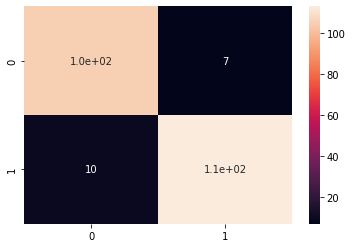

In [ ]:
CM=confusion_matrix(y_test,y_pred_rfe)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_rfe)
acc= accuracy_score(y_test, y_pred_rfe)
roc=roc_auc_score(y_test, y_pred_rfe)
prec = precision_score(y_test, y_pred_rfe)
rec = recall_score(y_test, y_pred_rfe)
f1 = f1_score(y_test, y_pred_rfe)

mathew = matthews_corrcoef(y_test, y_pred_rfe)
model_results =pd.DataFrame([['Random Forest',acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])

model_results

## Comparison with other Models

In [ ]:
data = {        'MLP': y_pred_mlp, 
                'KNN': y_pred_knn, 
                'EXtra tree classifier': y_pred_et_100,
                'XGB': y_pred_xgb, 
                'cat': y_pred_cat, 
                'bgg': y_pred_bgg,
                'Adaboost': y_pred_ada,  
                'GBM': y_pred_gbm }

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])
    
    mathew = matthews_corrcoef(y_test, models[column])
    results =pd.DataFrame([[column,acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])
    model_results = model_results.append(results, ignore_index = True)

model_results


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Random Forest,0.927660,0.941667,0.918699,0.937500,0.930041,0.928100,2.498574,0.855454
1,MLP,0.872340,0.911504,0.837398,0.910714,0.872881,0.874056,4.409240,0.747841
2,KNN,0.842553,0.852459,0.845528,0.839286,0.848980,0.842407,5.438081,0.684566
3,EXtra tree classifier,0.944681,0.950820,0.943089,0.946429,0.946939,0.944759,1.910676,0.889195
4,XGB,0.889362,0.929204,0.853659,0.928571,0.889831,0.891115,3.821339,0.781946
5,cat,0.902128,0.931034,0.878049,0.928571,0.903766,0.903310,3.380418,0.805802
6,bgg,0.914894,0.932773,0.902439,0.928571,0.917355,0.915505,2.939498,0.830167
7,Adaboost,0.834043,0.862069,0.813008,0.857143,0.836820,0.835075,5.732022,0.669471
8,GBM,0.846809,0.891892,0.804878,0.892857,0.846154,0.848868,5.291087,0.698039


### Findings
- AS we can see from above results, XGBoost Classifier is best performer as it has highest test accuracy of 0.9191, sensitivity of 0.943 and specificity of 0.89 and highest f1-score of 0.9243 and lowest Log Loss of 2079.


### ROC AUC Curve

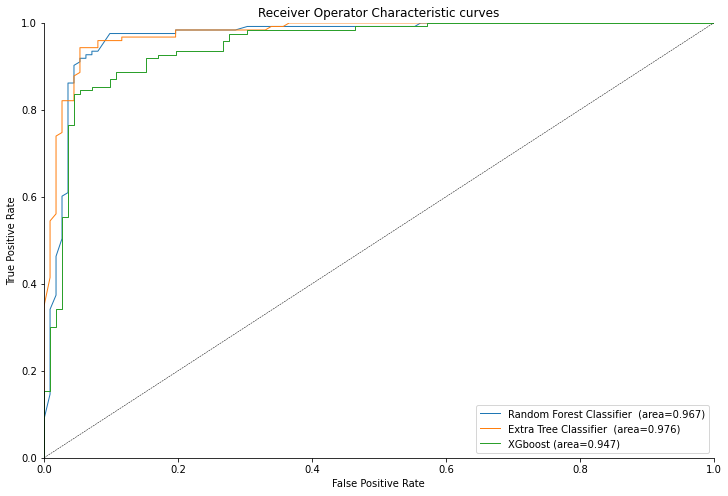

In [ ]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))

f, ax = plt.subplots(figsize=(12,8))


roc_auc_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
roc_auc_plot(y_test,et_100.predict_proba(X_test),label='Extra Tree Classifier ',l='-')
roc_auc_plot(y_test,xgb.predict_proba(X_test),label='XGboost',l='-')

ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        )    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

As we can see highest average area under the curve (AUC) of 0.950 is attained by Extra Tree Classifier

## Precision Recall curve

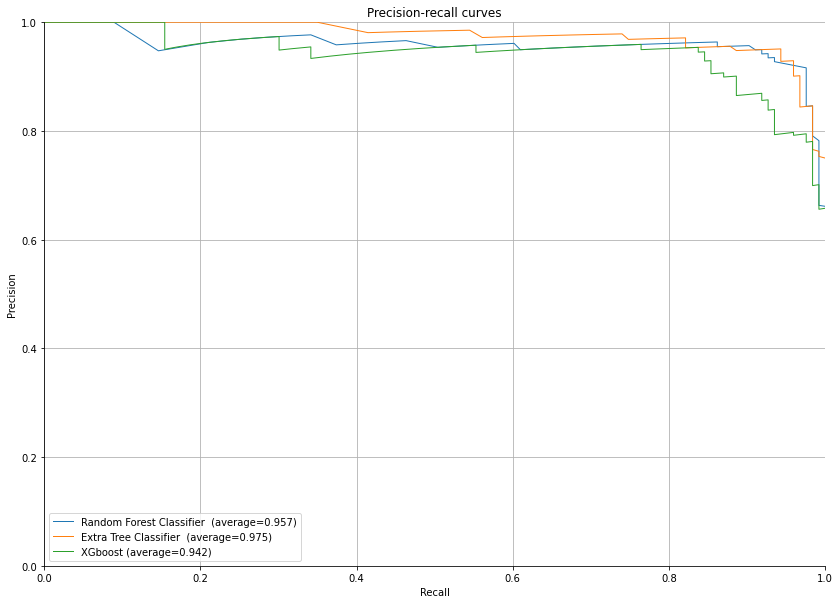

In [ ]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(14,10))

precision_recall_plot(y_test,rf_ent.predict_proba(X_test),label='Random Forest Classifier ',l='-')
precision_recall_plot(y_test,et_100.predict_proba(X_test),label='Extra Tree Classifier ',l='-')
precision_recall_plot(y_test,xgb.predict_proba(X_test),label='XGboost',l='-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="lower left")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()

### 11.  Feature Selection

In [ ]:
num_feats=11

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

11 selected features


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

11 selected features


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 15 features.
11 selected features


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", solver='lbfgs'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

7 selected features


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, criterion='gini'), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

8 selected features


In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

7 selected features


In [ ]:
# put all selection together
feature_name = X.columns
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,st_slope_flat,True,True,True,True,True,True,6
2,st_depression,True,True,True,True,True,True,6
3,max_heart_rate_achieved,True,True,True,False,True,True,5
4,exercise_induced_angina,True,True,True,False,True,True,5
5,cholesterol,True,False,True,True,True,True,5
6,age,True,True,True,False,True,True,5
7,st_slope_upsloping,True,True,True,False,True,False,4
8,sex_male,True,True,True,True,False,False,4
9,chest_pain_type_non-anginal pain,True,True,True,True,False,False,4
10,chest_pain_type_atypical angina,True,True,True,True,False,False,4


In [ ]:
# segregating dataset into features i.e., X and target variables i.e., y
X = dt.drop(['target','resting_blood_pressure','sex_male','chest_pain_type_non-anginal pain','chest_pain_type_atypical angina'],axis=1)
y = dt['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
130,0.204082,0.594705,0,0.466667,0,0.295455,0,0,1,0,1
73,0.326531,0.443992,0,0.355556,0,0.295455,0,0,0,0,1
1048,1.000000,0.619145,0,0.703704,1,0.295455,0,1,0,0,1
750,0.734694,0.501018,0,0.214815,1,0.545455,0,1,0,0,0
224,0.102041,0.606925,0,0.874074,0,0.295455,0,0,1,0,1


In [ ]:
X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

,age,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
885,0.591837,0.391039,0,0.600000,0,0.340909,0,0,1,1,0
55,0.469388,0.395112,0,0.762963,0,0.295455,0,0,1,0,1
686,0.387755,0.494908,0,0.629630,0,0.295455,0,0,1,0,1
1037,0.489796,0.606925,1,0.822222,0,0.431818,1,0,1,1,0
702,0.285714,0.496945,0,0.822222,0,0.386364,1,1,0,0,1


In [ ]:
import xgboost as xgb
import catboost as cat
models = GetBasedModel()
name,results = BasedLine2(X_train, y_train,models)
#print(models,results,X_train,y_train)


Streaming output truncated to the last 5000 lines.
11:	learn: 0.6143657	total: 17.7ms	remaining: 1.46s
12:	learn: 0.6091189	total: 19.2ms	remaining: 1.45s
13:	learn: 0.6036995	total: 20.6ms	remaining: 1.45s
14:	learn: 0.5982757	total: 22ms	remaining: 1.44s
15:	learn: 0.5931773	total: 23.3ms	remaining: 1.44s
16:	learn: 0.5882550	total: 24.7ms	remaining: 1.43s
17:	learn: 0.5823926	total: 26.3ms	remaining: 1.43s
18:	learn: 0.5785207	total: 27.7ms	remaining: 1.43s
19:	learn: 0.5734955	total: 29.1ms	remaining: 1.43s
20:	learn: 0.5675858	total: 30.5ms	remaining: 1.42s
21:	learn: 0.5633440	total: 31.9ms	remaining: 1.42s
22:	learn: 0.5589664	total: 33.7ms	remaining: 1.43s
23:	learn: 0.5543407	total: 35.3ms	remaining: 1.44s
24:	learn: 0.5512124	total: 36.2ms	remaining: 1.41s
25:	learn: 0.5476636	total: 37.4ms	remaining: 1.4s
26:	learn: 0.5436440	total: 38.9ms	remaining: 1.4s
27:	learn: 0.5403936	total: 40.2ms	remaining: 1.4s
28:	learn: 0.5367939	total: 41.6ms	remaining: 1.39s
29:	learn: 0.53235

## Soft voting

In [ ]:
import xgboost as xgb
import catboost as cat
clf1=RandomForestClassifier(criterion='entropy',n_estimators=100)

clf2=CatBoostClassifier(n_estimators= 1000)
clf3=xgb.XGBClassifier(n_estimators= 1000)
clf4=ExtraTreesClassifier(n_estimators= 500)

clf5=GradientBoostingClassifier(n_estimators=100,max_features='sqrt')


eclf1 = VotingClassifier(estimators=[('rfe', clf1), ('decc', clf2), ('xgb', clf3),('ET',clf4),('gb',clf5),], 
                         voting='soft', weights=[4,1,2,3,1])
eclf1.fit(X_train,y_train)
y_pred_sv =eclf1.predict(X_test)

Learning rate set to 0.01002
0:	learn: 0.6844952	total: 1.25ms	remaining: 1.25s
1:	learn: 0.6761242	total: 2.71ms	remaining: 1.35s
2:	learn: 0.6677804	total: 4.17ms	remaining: 1.39s
3:	learn: 0.6603995	total: 5.98ms	remaining: 1.49s
4:	learn: 0.6538270	total: 11.2ms	remaining: 2.24s
5:	learn: 0.6477651	total: 13.2ms	remaining: 2.19s
6:	learn: 0.6416282	total: 15.1ms	remaining: 2.14s
7:	learn: 0.6352702	total: 16.8ms	remaining: 2.08s
8:	learn: 0.6283585	total: 18.8ms	remaining: 2.06s
9:	learn: 0.6219740	total: 20.2ms	remaining: 2s
10:	learn: 0.6165089	total: 21.6ms	remaining: 1.94s
11:	learn: 0.6099630	total: 23ms	remaining: 1.89s
12:	learn: 0.6042261	total: 24.5ms	remaining: 1.86s
13:	learn: 0.5987139	total: 25.9ms	remaining: 1.83s
14:	learn: 0.5931817	total: 27.4ms	remaining: 1.8s
15:	learn: 0.5878640	total: 28.8ms	remaining: 1.77s
16:	learn: 0.5838029	total: 30.2ms	remaining: 1.75s
17:	learn: 0.5788789	total: 31.9ms	remaining: 1.74s
18:	learn: 0.5738781	total: 33.5ms	remaining: 1.73s

## 12 Model Evaluation

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,Soft Voting,0.902128,0.909836,0.902439,0.901786,0.906122,0.902112,3.380428,0.803933


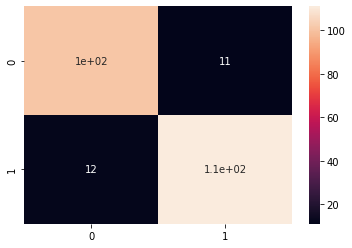

In [ ]:
CM=confusion_matrix(y_test,y_pred_sv)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_sv)
acc= accuracy_score(y_test, y_pred_sv)
roc=roc_auc_score(y_test, y_pred_sv)
prec = precision_score(y_test, y_pred_sv)
rec = recall_score(y_test, y_pred_sv)
f1 = f1_score(y_test, y_pred_sv)

mathew = matthews_corrcoef(y_test, y_pred_sv)
model_results =pd.DataFrame([['Soft Voting',acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])

model_results